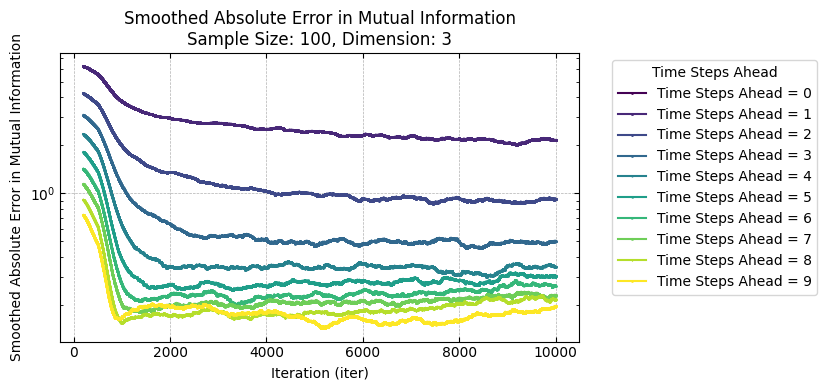

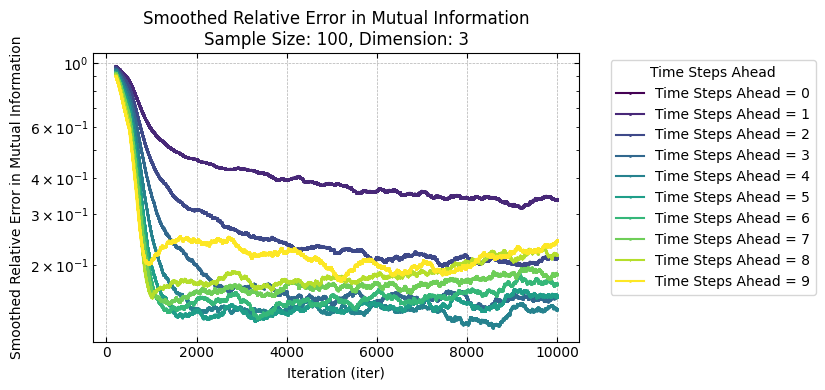

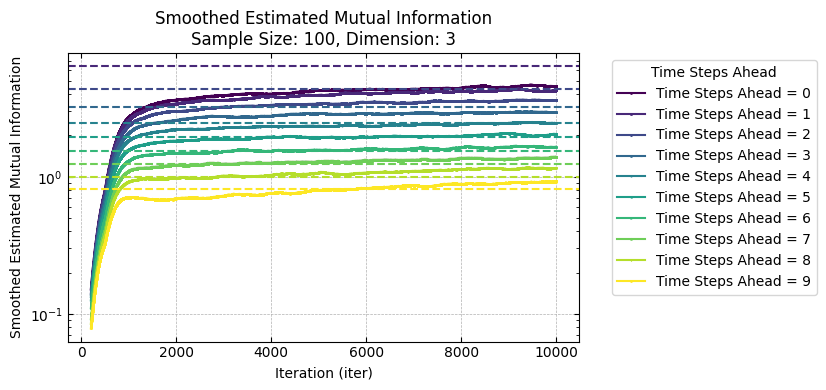

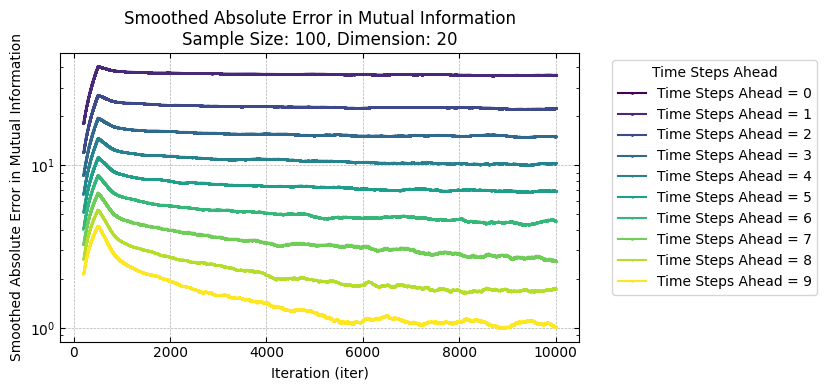

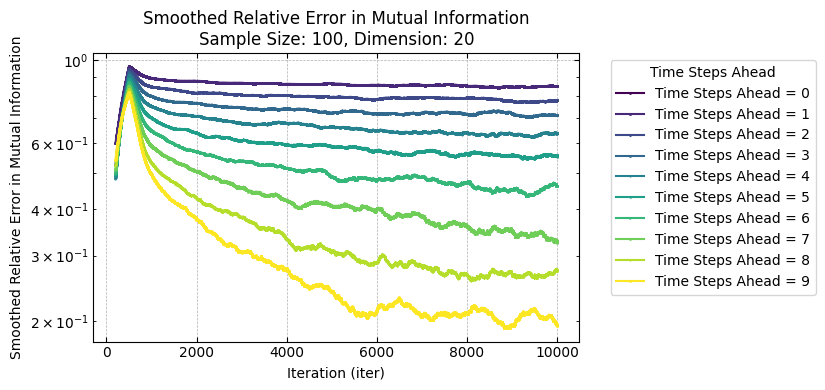

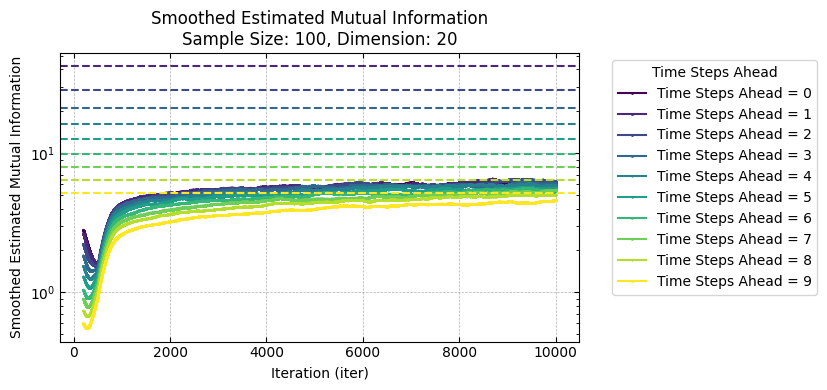

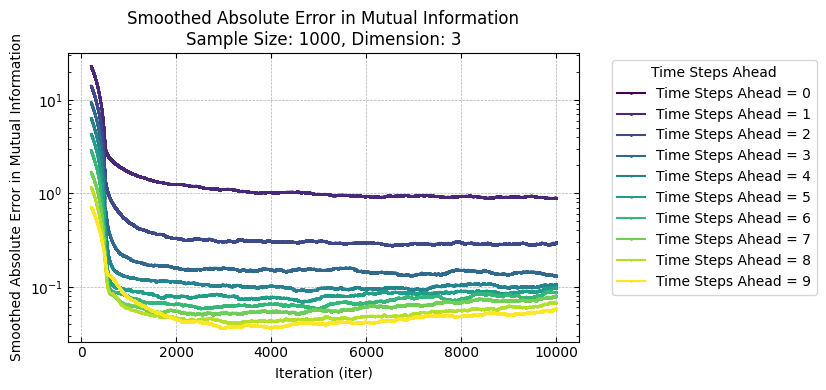

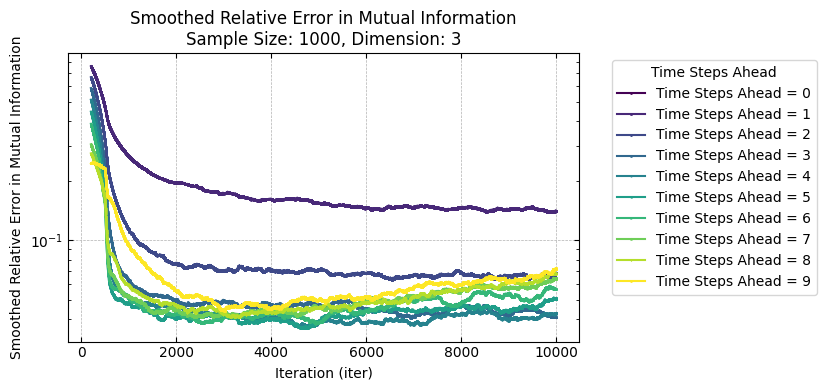

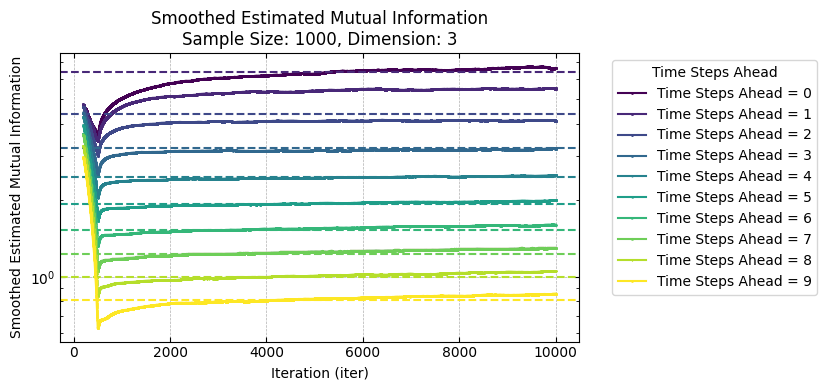

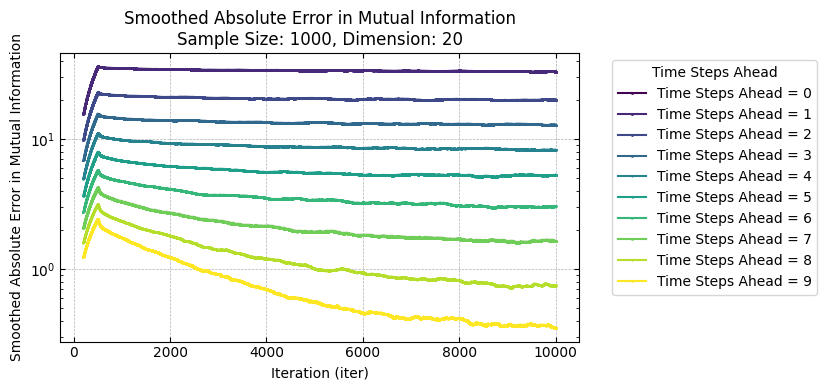

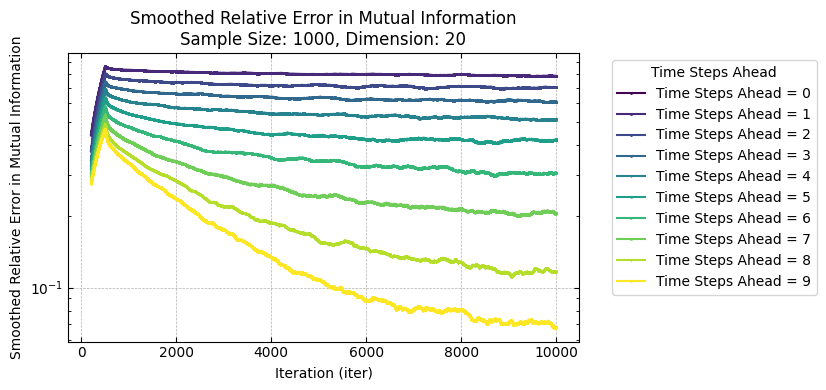

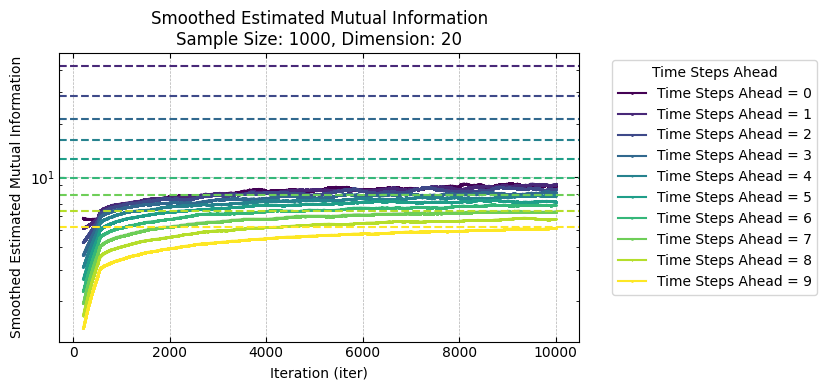

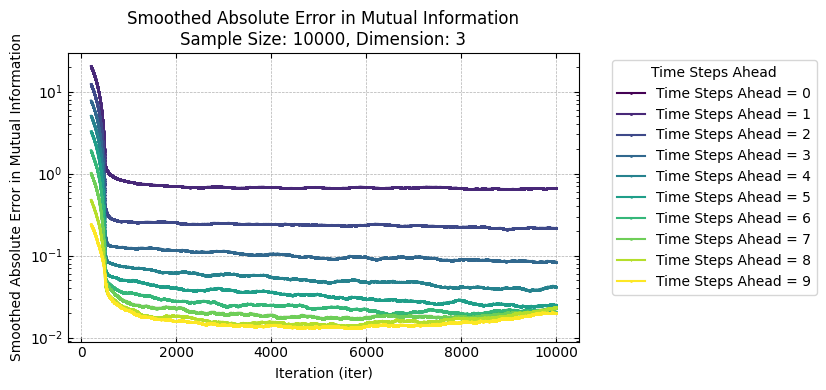

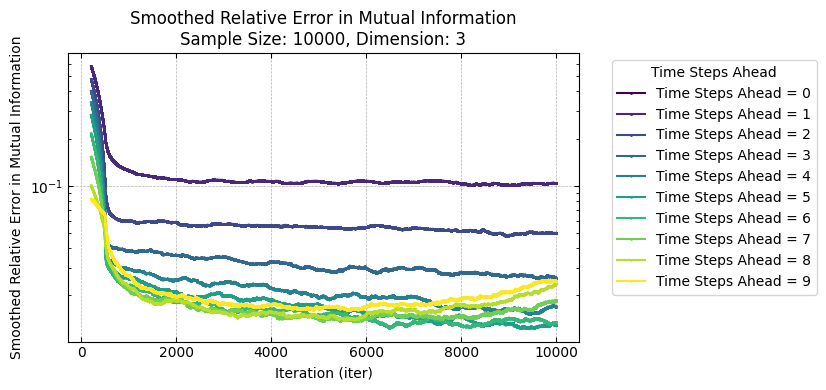

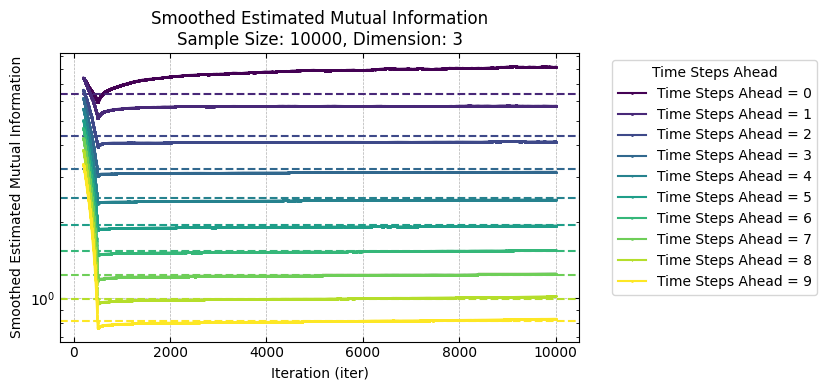

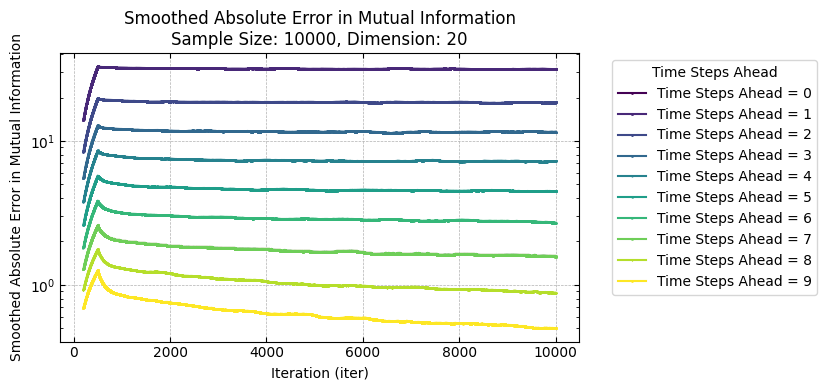

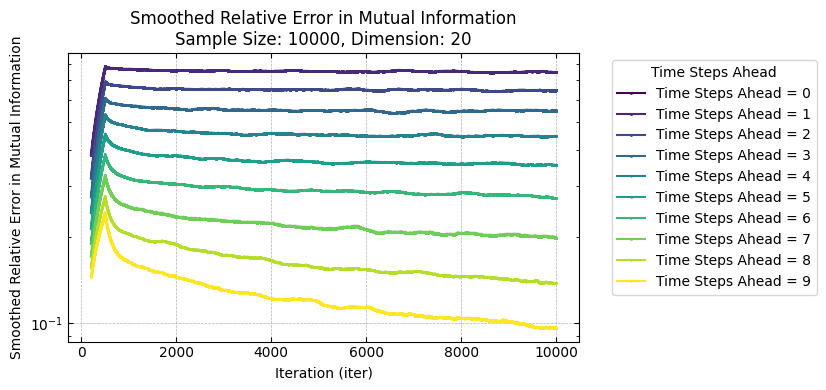

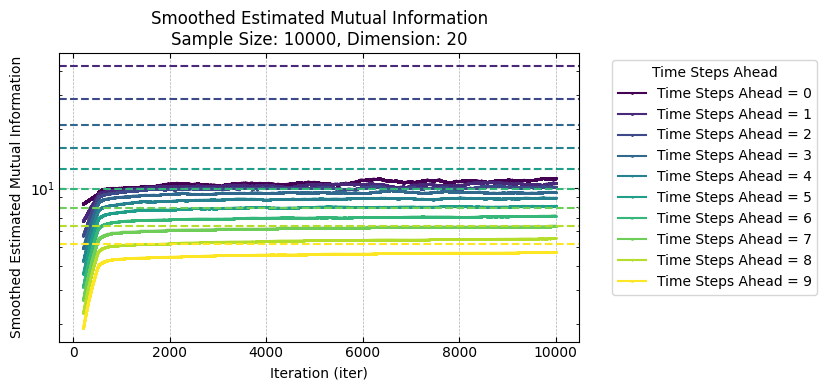

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def calculate_and_smooth_errors(df, window_size):
    """
    Calculate and smooth absolute and relative errors.
    
    :param df: DataFrame containing the experiment data.
    :param window_size: The size of the rolling window to smooth the errors.
    :return: DataFrame with smoothed error columns added.
    """
    # Calculate errors
    df['absolute_error'] = (df['estimated_mi'] - df['exact_mi']).abs()
    df['relative_error'] = df['absolute_error'] / df['exact_mi'].abs()
    
    # Smooth errors
    df['smoothed_absolute_error'] = df.groupby('time_steps_ahead')['absolute_error'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df['smoothed_relative_error'] = df.groupby('time_steps_ahead')['relative_error'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    
    return df

def plot_data(df, y_column, title, sample_size, dimension, burn_in=200, true_mi_lines=False):
    """
    General function to plot data from the DataFrame, skipping the first 'burn_in' values. Optionally plot horizontal
    lines for the true mutual information.
    
    :param df: DataFrame containing the filtered experiment data.
    :param y_column: Column name to be used as the y-axis in the plot.
    :param title: Title for the plot.
    :param sample_size: Sample size to display in the title.
    :param dimension: Dimension to display in the title.
    :param burn_in: Number of initial iterations to skip in the plot.
    :param true_mi_lines: Boolean, if True, plot horizontal lines for true mutual information.
    """
    colors = plt.cm.viridis(np.linspace(0, 1, df['time_steps_ahead'].nunique()))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'X', 'd', '|', '_']
    
    plt.figure(figsize=(10, 4))
    for idx, (time_steps_ahead, group_df) in enumerate(df.groupby('time_steps_ahead')):
        # Skip the first 'burn_in' values
        group_df = group_df.iloc[burn_in:]
        color = colors[idx % len(colors)]
        plt.plot(group_df['iter'], group_df[y_column],
                 label=f'Time Steps Ahead = {time_steps_ahead}',
                 marker=markers[idx % len(markers)], color=color, markersize=1)

        if true_mi_lines:
            # Draw horizontal lines for the true mutual information of each 'time_steps_ahead'
            true_mi = group_df['exact_mi'].iloc[0]  # Get the true MI for the current 'time_steps_ahead'
            plt.axhline(y=true_mi, color=color, linestyle='--')

    plt.xlabel('Iteration (iter)')
    plt.ylabel(title)
    plt.yscale('log')
    plt.title(f'{title}\nSample Size: {sample_size}, Dimension: {dimension}')
    plt.legend(title="Time Steps Ahead", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tick_params(direction='in', top=True, right=True, which='both')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


def main():
    df = pd.read_csv("./experiment_log.csv")
    window_size = 500

    # Calculate and smooth the errors
    df = calculate_and_smooth_errors(df, window_size)

    # Smooth the mutual information column
    df['smoothed_estimated_mi'] = df.groupby('time_steps_ahead')['estimated_mi'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    unique_combinations = df[['sample_size', 'dimension']].drop_duplicates()

    for _, row in unique_combinations.iterrows():
        sample_size_filter = row['sample_size']
        dimension_filter = row['dimension']

        # Filter the DataFrame based on sample size and dimension
        filtered_df = df.query('sample_size == @sample_size_filter and dimension == @dimension_filter')

        # Plot the smoothed errors without true MI horizontal lines
        plot_data(filtered_df, 'smoothed_absolute_error', 'Smoothed Absolute Error in Mutual Information', sample_size_filter, dimension_filter)
        plot_data(filtered_df, 'smoothed_relative_error', 'Smoothed Relative Error in Mutual Information', sample_size_filter, dimension_filter)
        
        # Plot the smoothed mutual information with true MI horizontal lines
        plot_data(filtered_df, 'smoothed_estimated_mi', 'Smoothed Estimated Mutual Information', sample_size_filter, dimension_filter, true_mi_lines=True)

if __name__ == '__main__':
    main()